### Basic imports

In [1]:
import pandas as pd
import sqlalchemy as sa
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os
from dotenv import load_dotenv
load_dotenv()

engine = sa.create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
    .format(host=os.getenv('host'), db=os.getenv('db'), user=os.getenv('uname'), pw=os.getenv('password')))


### 1. Read in Data from csv --> could also use pd.read_sql and use .env to load auth info

In [2]:
loan_data = pd.read_csv("raw_data/loans_v2.csv")
# format date columns to datetime data types
date_cols = [c for c in loan_data.columns if str(c)[-2:]=='Dt']
for col in date_cols:
    loan_data[col] = pd.to_datetime(loan_data[col], format='mixed')

# loan_data.to_sql(name='loan_tape_fv', con=engine, if_exists='replace', index=False)

In [3]:
def subset_dataframe(df, conditions, inverse=False):
    """return a subset of a dataframe based on multiple columns and conditions"""
    if not inverse:
        mask = pd.Series(True, index=df.index)
        for col, cond in conditions.items():
            mask &= df[col].isin(cond)
    else:
        mask = pd.Series(True, index=df.index)
        for col, cond in conditions.items():
            mask &= ~df[col].isin(cond)
    return df[mask]

In [4]:
# Slice the data frame to only 21+ year maturity loans
data_slice = loan_data[loan_data['MatBucket']=='8-11']

### 2. Use pool.py to organize cohorts --> loans are split into yyyy.mm cohorts

In [5]:
data_slice = loan_data[loan_data['MatBucket']=='8-11']
data_slice = data_slice[data_slice['Note_Yr']<=2021]

In [6]:
# top_5_states = data_slice[['GP','state_abbreviation','LoanAmt']].groupby('state_abbreviation').sum()[['LoanAmt']].sort_values('LoanAmt',ascending=False).head(5).index.to_list()

# data_slice[data_slice['state_abbreviation'].isin(top_5_states)]

In [7]:
data_slice[data_slice['NoteDt'].isna()]

,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,DefaultMthsQty,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr


In [8]:
data_slice

,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,DefaultMthsQty,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr
2,2022516,2001,2,2001-02-28,60000.00,2011-02-27,119,2011-09-13,NaN,2010-01-12,106.0,106.0,8-11,722514.0,"Cafeterias, Grill Buffets, and Buffets",0.0150,0.0125 - 0.015,NY,New York,2001.0
18,2380966,2003,7,2003-07-31,137800.00,2012-01-31,102,2013-03-31,NaN,2011-02-01,90.0,90.0,8-11,454390.0,Other Direct Selling Establishments,0.0275,0.025 - 0.0275,FL,Florida,2003.0
37,3994111,2004,12,2004-12-31,15000.00,2012-12-31,96,2012-06-15,89.0,2011-11-14,82.0,82.0,8-11,316998.0,All Other Leather Good and Allied Product Manu...,0.0150,0.0125 - 0.015,MA,Massachusetts,2004.0
52,4057302,2005,7,2005-07-31,75000.00,2013-10-14,98,2013-08-27,96.0,2013-06-21,94.0,94.0,8-11,621210.0,Offices of Dentists,0.0050,0.0 - 0.01,NY,New York,2005.0
53,4062322,2005,10,2005-10-31,104682.16,2015-05-01,114,2015-10-14,NaN,2015-04-30,113.0,113.0,8-11,812310.0,Coin-Operated Laundries and Drycleaners,0.0000,NaN,NY,New York,2005.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820417,17989821,2021,11,2021-11-30,340570.72,2031-11-30,120,NaT,NaN,NaT,NaN,NaN,8-11,NaN,NaN,0.0225,0.02 - 0.0225,OH,Ohio,NaN
820418,17990659,2021,11,2021-11-23,196600.00,2032-02-23,123,NaT,NaN,NaT,NaN,NaN,8-11,NaN,NaN,0.0275,0.025 - 0.0275,AL,Alabama,NaN
820420,17991714,2021,12,2021-12-31,95242.00,2031-12-29,119,NaT,NaN,NaT,NaN,NaN,8-11,NaN,NaN,0.0375,0.0275+,NY,New York,NaN
820421,17991919,2021,12,2021-12-31,150000.00,2031-12-07,119,NaT,NaN,NaT,NaN,NaN,8-11,NaN,NaN,0.0275,0.025 - 0.0275,FL,Florida,NaN


In [12]:
from pooler import pool

# Define a function to create static pools of Loans from the DataFrame
def create_pooler(in_df:pd.DataFrame)-> pool.Pooler:
    temp = in_df.set_index('GP')
    temp = temp.to_dict()
    loans_dict = {}
    for gp in temp['NoteDt'].keys():
        loans_dict[str(gp)] = pool.Loan(gp, pd.to_datetime(temp['NoteDt'][gp]))
        loans_dict[str(gp)].maturity_dt = temp['MaturityDt'][gp]
        loans_dict[str(gp)].maturity_mths_qty = temp['MaturityMthsQty'][gp]
        loans_dict[str(gp)].default_dt = temp['DefaultDt'][gp]
        loans_dict[str(gp)].default_mths_qty = temp['DefaultMthsQty'][gp]
        loans_dict[str(gp)].prepay_dt = temp['PrepayDt'][gp]
        loans_dict[str(gp)].prepay_mths_qty = temp['PrepayMthsQty'][gp]

    return pool.Pooler(loans_dict)

def outstanding_annual_rundown(in_arr):
    return in_arr[::11]

def aggregate_annual_sums(in_arr):
    remainder = len(in_arr) % 11
    if remainder != 0:
        padding = np.zeros(11 - remainder)
        subsections = np.concatenate([in_arr, padding])
    else:
        subsections = in_arr
    subsections = np.split(subsections, len(subsections) // 11)
    return (np.sum(subsections, axis=1))

def aggregate_annual_averages(in_arr):
    n_years = len(in_arr) // 11
    arr_2d = in_arr[:n_years*11].reshape(n_years,11)
    return np.nanmean(arr_2d, axis=1)

def aggregate_annual_median(in_arr):
    n_years = len(in_arr) // 11
    arr_2d = in_arr[:n_years*11].reshape(n_years,11)
    return np.nanmedian(arr_2d, axis=1)

def enforce_shape(in_df:pd.DataFrame)->pd.DataFrame:
    data = in_df.copy(deep=True)
    last_year = data.index.max()+1
    for i in range(len(data)):
        max_col = last_year - data.index[i]
        data.iloc[i,(max_col):] = np.NaN
    return data

def generate_lifetime(cpr_df:pd.DataFrame)-> pd.DataFrame:
    # get the cumulative sum of each row WHILE ignoring NaN values (otherwise the denominator is off)
    cumulative_sum = np.nancumsum(cpr_df.values, axis=1)
    # compute the number of non-NaN values in each row
    num_non_nan = (~np.isnan(cpr_df.values)).cumsum(axis=1)
    # get ROW-WISE average up until the first NaN value is encountered
    row_avg = np.where(np.isnan(cpr_df), np.nan, cumulative_sum / num_non_nan)
    # create new dataframe with row-wise averages
    lifetime_df = pd.DataFrame(row_avg, columns=cpr_df.columns, index=cpr_df.index)
    return lifetime_df


test_slice = data_slice.copy()

balance_buckets = [0,50_000,250_000,350_000,np.inf]

test_slice['bal_buckets']= pd.cut(test_slice['LoanAmt'], balance_buckets)

margin_buckets = [0,.01,.02,.0275,np.inf]

test_slice['MarginBucket'] = pd.cut(test_slice['Margin'], margin_buckets)

test_slice = test_slice[~test_slice['bal_buckets'].isna()]


for b in test_slice['bal_buckets'].value_counts().index.to_list():
    for m in test_slice['MarginBucket'].value_counts().index.to_list():
        
        mask = (test_slice['bal_buckets']==b)&(test_slice['MarginBucket']==m)
        subset = test_slice[mask]
    
        
        my_pooler = create_pooler(subset)
        my_pooler.build_triangles_counts()

        pool_dict = {}
        for k, v in my_pooler.triangles.items():
            pool_dict[k] = dict(outstanding=v[0], prepayments=v[1], defaults=v[2])
        
        # Create Pool Dataframe
        df_pool = pd.DataFrame.from_dict( pool_dict, orient='index')
        df_pool.index = [float(e) for e in df_pool.index.to_list()]
        df_pool = df_pool.sort_index()

        # Format array lengths
        max_row_length = df_pool.shape[0]
        count = -1
        for i, row in df_pool.iterrows():
            count+=1
            for col in df_pool.columns:
                arr = row[col][:(max_row_length-count)].astype(float)
                padded_arr = np.pad(arr, (0, max_row_length - (max_row_length-count) ), mode='constant', constant_values=np.nan)
                df_pool.at[i,col] = padded_arr
        # Format array lengths
        max_row_length = df_pool.shape[0]
        count = -1
        for i, row in df_pool.iterrows():
            count+=1
            for col in df_pool.columns:
                arr = row[col][:(max_row_length-count)].astype(float)
                padded_arr = np.pad(arr, (0, max_row_length - (max_row_length-count) ), mode='constant', constant_values=np.nan)
                df_pool.at[i,col] = padded_arr

        # This is where we start abstracting away from the Data --> you're now looking at Annual Cohorts grouped together
        df_pool['Year'] = df_pool.index.astype(int)
        # Filter out years without 12 months of history
        vals = df_pool['Year'].value_counts().to_dict()

        yr_range = []
        for k, v in vals.items():
            if v == 12:
                yr_range.append(k)

        df_pool = df_pool[df_pool['Year'].isin(yr_range)]
        try:
        # Switch to year group
            year_grouped = df_pool.groupby('Year')
            year_grouped = year_grouped.agg(np.nansum)
            year_grouped['outstanding'] = year_grouped['outstanding'].apply(outstanding_annual_rundown)
            year_grouped[['prepayments','defaults']] = year_grouped[['prepayments','defaults']].applymap(aggregate_annual_sums)
            year_grouped['cpr'] = (year_grouped['prepayments']+year_grouped['defaults'])/year_grouped['outstanding']
            # year_grouped['cpr'] = (1-(1-year_grouped['smm'])**12)
        except:
            raise
        cpr_heat = pd.DataFrame.from_dict(year_grouped['cpr'].to_dict(), orient='index')

        cpr_heat = enforce_shape(cpr_heat)
        lifetime_cprs = generate_lifetime(cpr_heat)
        totals = year_grouped[['outstanding']].to_dict()
        prepays = year_grouped[['prepayments']].to_dict()
        defaults = year_grouped[['defaults']].to_dict()
        totals = totals['outstanding']
        prepays = prepays['prepayments']
        defaults = defaults['defaults']
        totals = (pd.DataFrame.from_dict(totals, orient='index'))
        prepays = (pd.DataFrame.from_dict(prepays, orient='index'))
        defaults = (pd.DataFrame.from_dict(defaults, orient='index'))
        totals = enforce_shape(totals)
        prepays = enforce_shape(prepays)
        defaults = enforce_shape(defaults)
        triangles = [totals,prepays,defaults]
        totals = pd.concat(triangles,axis=0)
        min_max_median = pd.DataFrame.from_dict({'max': cpr_heat.max(axis=0), 'median': cpr_heat.median(axis=0), 'avg': cpr_heat.mean(axis=0),\
                                                'min': cpr_heat.min(axis=0)}).transpose()


        # NOTE--<TOCSV BELOW>
        if f'{b}-{m}' not in os.listdir('manual_outputs/'):
            os.mkdir(f'manual_outputs/combos/{b}-{m}')

        cpr_heat.to_csv(f'manual_outputs/combos/{b}-{m}/cpr_heat.csv')
        lifetime_cprs.to_csv(f'manual_outputs/combos/{b}-{m}/lifetime.csv')
        min_max_median.to_csv(f'manual_outputs/combos/{b}-{m}/min_max_mids.csv')
        totals.to_csv(f'manual_outputs/combos/{b}-{m}/totals.csv')

,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,...,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr,bal_buckets
18,2380966,2003,7,2003-07-31,137800.00,2012-01-31,102,2013-03-31,NaN,2011-02-01,...,90.0,8-11,454390.0,Other Direct Selling Establishments,0.0275,"(0.02, 0.0275]",FL,Florida,2003.0,"(50000.0, 250000.0]"
175,3954044,2004,4,2004-04-30,70000.00,2014-04-30,120,2018-02-01,NaN,2009-12-17,...,67.0,8-11,722330.0,Mobile Food Services,0.0275,"(0.02, 0.0275]",NY,New York,2004.0,"(50000.0, 250000.0]"
178,4165434,2004,12,2004-12-31,72700.00,2014-12-31,120,2014-09-30,116.0,2013-08-02,...,103.0,8-11,485999.0,All Other Transit and Ground Passenger Transpo...,0.0275,"(0.02, 0.0275]",CA,California,2004.0,"(50000.0, 250000.0]"
198,4578131,2005,10,2005-10-31,149898.89,2015-05-04,114,2015-08-31,NaN,NaT,...,NaN,8-11,541618.0,Other Management Consulting Services,0.0250,"(0.02, 0.0275]",MD,Maryland,2005.0,"(50000.0, 250000.0]"
224,1479126,2000,4,2000-04-30,170000.00,2010-04-30,120,2006-08-28,75.0,2000-09-18,...,4.0,8-11,722511.0,Full-Service Restaurants,0.0275,"(0.02, 0.0275]",VA,Virginia,2000.0,"(50000.0, 250000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820377,15974262,2021,4,2021-04-30,240000.00,2031-04-27,119,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0275,"(0.02, 0.0275]",CA,California,NaN,"(50000.0, 250000.0]"
820383,17971058,2021,10,2021-10-31,218000.00,2031-08-02,117,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0275,"(0.02, 0.0275]",OR,Oregon,NaN,"(50000.0, 250000.0]"
820390,17977468,2021,8,2021-08-31,242000.00,2031-08-16,119,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0275,"(0.02, 0.0275]",PA,Pennsylvania,NaN,"(50000.0, 250000.0]"
820418,17990659,2021,11,2021-11-23,196600.00,2032-02-23,123,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0275,"(0.02, 0.0275]",AL,Alabama,NaN,"(50000.0, 250000.0]"


,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,...,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr,bal_buckets
2,2022516,2001,2,2001-02-28,60000.00,2011-02-27,119,2011-09-13,NaN,2010-01-12,...,106.0,8-11,722514.0,"Cafeterias, Grill Buffets, and Buffets",0.0150,"(0.01, 0.02]",NY,New York,2001.0,"(50000.0, 250000.0]"
477,1482715,2000,3,2000-03-31,55000.00,2010-03-31,120,2002-07-31,28.0,NaT,...,28.0,8-11,238210.0,Electrical Contractors,0.0200,"(0.01, 0.02]",AR,Arkansas,2000.0,"(50000.0, 250000.0]"
494,1488989,2000,8,2000-08-31,137241.02,2010-08-31,120,2007-02-28,77.0,NaT,...,77.0,8-11,541940.0,Veterinary Services,0.0200,"(0.01, 0.02]",MN,Minnesota,2000.0,"(50000.0, 250000.0]"
513,1496263,2000,6,2000-06-30,181000.00,2010-06-30,120,2004-11-30,53.0,NaT,...,53.0,8-11,457120.0,Other Gasoline Stations,0.0150,"(0.01, 0.02]",IN,Indiana,2000.0,"(50000.0, 250000.0]"
521,1499502,2000,9,2000-09-30,125000.00,2010-09-30,120,2008-08-31,95.0,NaT,...,95.0,8-11,238220.0,"Plumbing, Heating, and Air-Conditioning Contra...",0.0150,"(0.01, 0.02]",MN,Minnesota,2000.0,"(50000.0, 250000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820291,4995349,2017,6,2017-06-30,158000.00,2027-06-02,119,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0200,"(0.01, 0.02]",NC,North Carolina,NaN,"(50000.0, 250000.0]"
820303,5029316,2018,2,2018-02-28,180000.00,2027-12-14,117,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0150,"(0.01, 0.02]",MD,Maryland,NaN,"(50000.0, 250000.0]"
820355,5144529,2020,3,2020-03-31,85000.00,2030-01-30,117,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0175,"(0.01, 0.02]",IL,Illinois,NaN,"(50000.0, 250000.0]"
820375,13535463,2021,3,2021-03-26,75000.00,2031-03-17,119,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0200,"(0.01, 0.02]",MO,Missouri,NaN,"(50000.0, 250000.0]"


,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,...,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr,bal_buckets
269,3944713,2004,2,2004-02-29,52093.55,2014-02-28,119,2012-10-31,104.0,2012-09-21,...,102.0,8-11,238140.0,Masonry Contractors,0.0650,"(0.0275, inf]",IL,Illinois,2004.0,"(50000.0, 250000.0]"
1000,2341269,2002,11,2002-11-30,89490.41,2012-11-30,120,2010-06-11,90.0,2010-04-02,...,88.0,8-11,541211.0,Offices of Certified Public Accountants,0.0650,"(0.0275, inf]",WA,Washington,2002.0,"(50000.0, 250000.0]"
1155,2391975,2004,2,2004-02-29,55798.68,2012-07-19,100,2011-05-20,86.0,2011-05-13,...,86.0,8-11,484121.0,"General Freight Trucking, Long-Distance, Truck...",0.0575,"(0.0275, inf]",CA,California,2004.0,"(50000.0, 250000.0]"
1468,4010165,2005,3,2005-03-31,100000.00,2013-07-21,99,2012-10-31,91.0,2011-08-25,...,76.0,8-11,444220.0,"Nursery, Garden Center, and Farm Supply Stores",0.0600,"(0.0275, inf]",PA,Pennsylvania,2005.0,"(50000.0, 250000.0]"
1897,4323153,2006,11,2006-11-30,111746.96,2016-09-10,117,2016-08-31,117.0,NaT,...,117.0,8-11,541110.0,Offices of Lawyers,0.0405,"(0.0275, inf]",OH,Ohio,2006.0,"(50000.0, 250000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820316,5052045,2018,5,2018-05-31,100000.00,2028-04-30,118,2022-03-04,45.0,NaT,...,45.0,8-11,NaN,NaN,0.0300,"(0.0275, inf]",CA,California,NaN,"(50000.0, 250000.0]"
820336,5090491,2019,1,2019-01-31,250000.00,2028-12-21,118,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0450,"(0.0275, inf]",CO,Colorado,NaN,"(50000.0, 250000.0]"
820371,10702881,2020,12,2020-12-22,100000.00,2030-12-22,120,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0400,"(0.0275, inf]",CA,California,NaN,"(50000.0, 250000.0]"
820400,17983769,2021,11,2021-11-19,250000.00,2031-11-19,120,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0300,"(0.0275, inf]",NC,North Carolina,NaN,"(50000.0, 250000.0]"


,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,...,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr,bal_buckets
52,4057302,2005,7,2005-07-31,75000.0,2013-10-14,98,2013-08-27,96.0,2013-06-21,...,94.0,8-11,621210.0,Offices of Dentists,0.00500,"(0.0, 0.01]",NY,New York,2005.0,"(50000.0, 250000.0]"
506,1494026,2000,9,2000-09-30,90000.0,2010-09-30,120,2003-06-30,33.0,NaT,...,33.0,8-11,333311.0,Automatic Vending Machine Manufacturing,0.00750,"(0.0, 0.01]",OK,Oklahoma,2000.0,"(50000.0, 250000.0]"
528,1502034,2000,6,2000-06-30,95000.0,2010-06-30,120,2002-08-31,26.0,NaT,...,26.0,8-11,421940.0,"Jewelry, Watch, Precious Stone, and Precious M...",0.01000,"(0.0, 0.01]",IL,Illinois,2000.0,"(50000.0, 250000.0]"
569,2009601,2000,12,2000-12-31,125000.0,2010-12-31,120,2003-06-30,29.0,NaT,...,29.0,8-11,234990.0,All Other Heavy Construction,0.00200,"(0.0, 0.01]",AK,Alaska,2000.0,"(50000.0, 250000.0]"
716,2043754,2001,8,2001-08-31,80000.0,2011-08-31,120,2004-10-31,38.0,NaT,...,38.0,8-11,811118.0,Other Automotive Mechanical and Electrical Rep...,0.00275,"(0.0, 0.01]",TX,Texas,2001.0,"(50000.0, 250000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819848,1476940,2000,2,2000-02-29,150000.0,2008-02-29,96,2002-03-31,25.0,NaT,...,25.0,8-11,-1.0,NaN,0.00225,"(0.0, 0.01]",CT,Connecticut,NaN,"(50000.0, 250000.0]"
819970,2220823,2002,8,2002-08-31,65000.0,2012-08-31,120,2004-11-30,26.0,NaT,...,26.0,8-11,NaN,NaN,0.00275,"(0.0, 0.01]",CA,California,NaN,"(50000.0, 250000.0]"
819994,2384853,2003,7,2003-07-31,90000.0,2011-10-31,99,2005-09-30,25.0,NaT,...,25.0,8-11,NaN,NaN,0.00200,"(0.0, 0.01]",MO,Missouri,NaN,"(50000.0, 250000.0]"
820130,2195111,2001,10,2001-10-31,63998.3,2011-10-31,120,2011-08-31,118.0,NaT,...,118.0,8-11,NaN,NaN,0.00100,"(0.0, 0.01]",KS,Kansas,NaN,"(50000.0, 250000.0]"


,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,...,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr,bal_buckets
467,1476597,2000,1,2000-01-31,1250000.00,2010-01-31,120,2007-05-31,88.0,NaT,...,88.0,8-11,421450.0,"Medical, Dental, and Hospital Equipment and Su...",0.0250,"(0.02, 0.0275]",FL,Florida,2000.0,"(350000.0, inf]"
498,1490502,2000,4,2000-04-30,384000.00,2010-04-30,120,2001-12-31,20.0,NaT,...,20.0,8-11,422480.0,Fresh Fruit and Vegetable Wholesalers,0.0250,"(0.02, 0.0275]",CA,California,2000.0,"(350000.0, inf]"
570,2009692,2000,12,2000-12-31,358200.00,2010-12-31,120,2005-11-30,58.0,NaT,...,58.0,8-11,493120.0,Refrigerated Warehousing and Storage,0.0275,"(0.02, 0.0275]",OR,Oregon,2000.0,"(350000.0, inf]"
622,2021424,2001,3,2001-03-31,850000.00,2011-03-31,120,2011-02-28,118.0,NaT,...,118.0,8-11,812331.0,Linen Supply,0.0250,"(0.02, 0.0275]",NV,Nevada,2001.0,"(350000.0, inf]"
722,2046612,2001,9,2001-09-30,355000.00,2011-09-30,120,2006-09-29,59.0,2005-12-13,...,50.0,8-11,337122.0,Nonupholstered Wood Household Furniture Manufa...,0.0250,"(0.02, 0.0275]",CA,California,2001.0,"(350000.0, inf]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820382,17970790,2021,7,2021-07-13,2173000.00,2031-07-13,120,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0275,"(0.02, 0.0275]",NY,New York,NaN,"(350000.0, inf]"
820388,17975543,2021,8,2021-08-31,630000.00,2031-08-27,119,2021-12-31,4.0,NaT,...,4.0,8-11,NaN,NaN,0.0275,"(0.02, 0.0275]",VA,Virginia,NaN,"(350000.0, inf]"
820393,17979310,2021,9,2021-09-30,3232000.00,2031-09-28,119,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0275,"(0.02, 0.0275]",IL,Illinois,NaN,"(350000.0, inf]"
820411,17987285,2021,10,2021-10-31,742000.00,2031-10-27,119,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0250,"(0.02, 0.0275]",LA,Louisiana,NaN,"(350000.0, inf]"


,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,...,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr,bal_buckets
233,1498023,2000,5,2000-05-31,1000000.00,2010-05-31,120,2003-11-05,41.0,2000-11-30,...,5.0,8-11,311421.0,Fruit and Vegetable Canning,0.0200,"(0.01, 0.02]",MA,Massachusetts,2000.0,"(350000.0, inf]"
473,1481866,2000,2,2000-02-29,400000.00,2010-02-28,119,2001-06-30,16.0,NaT,...,16.0,8-11,457120.0,Other Gasoline Stations,0.0200,"(0.01, 0.02]",TX,Texas,2000.0,"(350000.0, inf]"
591,2014288,2001,1,2001-01-31,780000.00,2011-01-31,120,2004-04-30,38.0,NaT,...,38.0,8-11,722511.0,Full-Service Restaurants,0.0150,"(0.01, 0.02]",MD,Maryland,2001.0,"(350000.0, inf]"
642,2026592,2001,3,2001-03-31,365000.00,2011-03-31,120,2005-03-31,48.0,NaT,...,48.0,8-11,811219.0,Other Electronic and Precision Equipment Repai...,0.0150,"(0.01, 0.02]",MI,Michigan,2001.0,"(350000.0, inf]"
678,2034709,2001,5,2001-05-31,1333000.00,2011-05-31,120,2008-10-27,88.0,2003-02-03,...,20.0,8-11,334418.0,Printed Circuit Assembly (Electronic Assembly)...,0.0200,"(0.01, 0.02]",CA,California,2001.0,"(350000.0, inf]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820329,5074800,2019,2,2019-02-28,1768000.00,2028-09-25,114,2021-06-30,28.0,NaT,...,28.0,8-11,NaN,NaN,0.0125,"(0.01, 0.02]",CA,California,NaN,"(350000.0, inf]"
820353,5136805,2019,12,2019-12-31,1710000.00,2029-11-25,118,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0125,"(0.01, 0.02]",TX,Texas,NaN,"(350000.0, inf]"
820397,17982555,2021,9,2021-09-30,960000.00,2031-09-12,119,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0200,"(0.01, 0.02]",WI,Wisconsin,NaN,"(350000.0, inf]"
820402,17984275,2021,9,2021-09-30,397860.47,2032-03-31,126,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0150,"(0.01, 0.02]",TN,Tennessee,NaN,"(350000.0, inf]"


,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,...,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr,bal_buckets
9180,4634698,2011,8,2011-08-01,717533.88,2021-06-20,118,2019-11-30,99.0,NaT,...,99.0,8-11,523140.0,Commodity Contracts Brokerage,0.04500,"(0.0275, inf]",UT,Utah,2011.0,"(350000.0, inf]"
11840,1497243,2000,5,2000-05-31,1000000.00,2010-05-25,119,2016-06-27,NaN,2001-03-21,...,9.0,8-11,235990.0,All Other Special Trade Contractors,0.03250,"(0.0275, inf]",IL,Illinois,2000.0,"(350000.0, inf]"
16327,4979777,2017,10,2017-10-31,659000.00,2027-03-10,112,2018-10-31,12.0,NaT,...,12.0,8-11,312120.0,Breweries,0.02850,"(0.0275, inf]",CA,California,2017.0,"(350000.0, inf]"
17026,5135115,2019,12,2019-12-31,500000.00,2029-11-08,118,NaT,NaN,NaT,...,NaN,8-11,114111.0,Finfish Fishing,0.03000,"(0.0275, inf]",CA,California,2019.0,"(350000.0, inf]"
20821,4632330,2011,5,2011-05-24,834700.00,2021-05-24,120,2017-05-31,72.0,NaT,...,72.0,8-11,812111.0,Barber Shops,0.03814,"(0.0275, inf]",OK,Oklahoma,2011.0,"(350000.0, inf]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810754,5003267,2017,7,2017-07-31,598175.00,2025-08-15,96,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.04000,"(0.0275, inf]",MN,Minnesota,NaN,"(350000.0, inf]"
811341,4768135,2014,5,2014-05-08,668151.44,2024-05-08,120,2020-01-31,68.0,NaT,...,68.0,8-11,NaN,NaN,0.02900,"(0.0275, inf]",UT,Utah,NaN,"(350000.0, inf]"
813878,4652770,2012,1,2012-01-01,500514.41,2022-12-01,131,2021-04-30,111.0,NaT,...,111.0,8-11,NaN,NaN,0.03000,"(0.0275, inf]",VT,Vermont,NaN,"(350000.0, inf]"
814390,4218617,2005,8,2005-08-31,368648.25,2015-08-31,120,2015-06-30,117.0,NaT,...,117.0,8-11,NaN,NaN,0.06500,"(0.0275, inf]",NE,Nebraska,NaN,"(350000.0, inf]"


,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,...,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr,bal_buckets
509,1495489,2000,4,2000-04-30,650000.00,2010-04-30,120,2008-03-31,95.0,NaT,...,95.0,8-11,421820.0,Farm and Garden Machinery and Equipment Wholes...,0.01000,"(0.0, 0.01]",TX,Texas,2000.0,"(350000.0, inf]"
721,2046052,2001,11,2001-11-30,410000.00,2011-11-30,120,2011-09-30,118.0,NaT,...,118.0,8-11,541211.0,Offices of Certified Public Accountants,0.01000,"(0.0, 0.01]",MO,Missouri,2001.0,"(350000.0, inf]"
745,2050734,2001,11,2001-11-30,400000.00,2011-11-30,120,2005-04-30,41.0,NaT,...,41.0,8-11,323110.0,Commercial Lithographic Printing,0.01000,"(0.0, 0.01]",IL,Illinois,2001.0,"(350000.0, inf]"
1205,3916983,2004,9,2004-09-30,458750.38,2014-09-29,119,NaT,NaN,NaT,...,NaN,8-11,561421.0,Telephone Answering Services,0.01000,"(0.0, 0.01]",NY,New York,2004.0,"(350000.0, inf]"
1574,4152251,2004,11,2004-11-30,450000.00,2014-11-30,120,2008-05-12,41.0,2005-10-13,...,10.0,8-11,722513.0,Limited-Service Restaurants,0.00275,"(0.0, 0.01]",TX,Texas,2004.0,"(350000.0, inf]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819889,1496177,2000,5,2000-05-31,425000.00,2010-05-31,120,2005-10-31,65.0,NaT,...,65.0,8-11,-1.0,NaN,0.01000,"(0.0, 0.01]",TX,Texas,NaN,"(350000.0, inf]"
819988,2358240,2003,5,2003-05-31,450000.00,2013-05-31,120,2011-10-31,101.0,NaT,...,101.0,8-11,NaN,NaN,0.00275,"(0.0, 0.01]",AR,Arkansas,NaN,"(350000.0, inf]"
820307,5039723,2018,3,2018-03-31,5000000.00,2028-02-16,118,2019-03-18,11.0,NaT,...,11.0,8-11,NaN,NaN,0.01000,"(0.0, 0.01]",TX,Texas,NaN,"(350000.0, inf]"
820328,5073193,2018,10,2018-10-31,399000.00,2027-02-07,99,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.01000,"(0.0, 0.01]",NE,Nebraska,NaN,"(350000.0, inf]"


,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,...,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr,bal_buckets
448,1487866,2000,4,2000-04-30,265000.00,2010-04-30,120,2002-07-23,26.0,2001-01-26,...,8.0,8-11,722511.0,Full-Service Restaurants,0.0250,"(0.02, 0.0275]",GA,Georgia,2000.0,"(250000.0, 350000.0]"
500,1491318,2000,3,2000-03-31,264000.00,2010-03-31,120,2006-03-31,72.0,NaT,...,72.0,8-11,812320.0,Drycleaning and Laundry Services (except Coin-...,0.0275,"(0.02, 0.0275]",KY,Kentucky,2000.0,"(250000.0, 350000.0]"
503,1493039,2000,8,2000-08-31,320500.00,2009-08-31,108,2003-11-30,38.0,NaT,...,38.0,8-11,561439.0,Other Business Service Centers (including Copy...,0.0250,"(0.02, 0.0275]",CA,California,2000.0,"(250000.0, 350000.0]"
595,2015048,2001,2,2001-02-28,335000.00,2011-02-28,120,2004-03-31,37.0,NaT,...,37.0,8-11,453220.0,"Gift, Novelty, and Souvenir Stores",0.0250,"(0.02, 0.0275]",NJ,New Jersey,2001.0,"(250000.0, 350000.0]"
604,2017665,2001,1,2001-01-31,256000.00,2011-01-31,120,2008-09-03,91.0,2002-08-22,...,18.0,8-11,811111.0,General Automotive Repair,0.0250,"(0.02, 0.0275]",AZ,Arizona,2001.0,"(250000.0, 350000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820363,10268799,2020,8,2020-08-31,275000.00,2030-07-29,118,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0275,"(0.02, 0.0275]",NY,New York,NaN,"(250000.0, 350000.0]"
820378,16538729,2021,5,2021-05-05,350000.00,2031-05-03,119,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0275,"(0.02, 0.0275]",NC,North Carolina,NaN,"(250000.0, 350000.0]"
820410,17987065,2021,10,2021-10-27,350000.00,2031-10-21,119,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0275,"(0.02, 0.0275]",WA,Washington,NaN,"(250000.0, 350000.0]"
820413,17988186,2021,12,2021-12-09,300000.00,2031-12-03,119,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0225,"(0.02, 0.0275]",IN,Indiana,NaN,"(250000.0, 350000.0]"


,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,...,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr,bal_buckets
471,1480565,2000,4,2000-04-30,302100.00,2010-04-30,120,2009-08-31,112.0,2003-10-16,...,41.0,8-11,234110.0,Highway and Street Construction,0.0175,"(0.01, 0.02]",TN,Tennessee,2000.0,"(250000.0, 350000.0]"
508,1495049,2000,4,2000-04-30,350000.00,2010-04-30,120,2003-02-28,33.0,NaT,...,33.0,8-11,524210.0,Insurance Agencies and Brokerages,0.0200,"(0.01, 0.02]",TX,Texas,2000.0,"(250000.0, 350000.0]"
680,2034886,2001,8,2001-08-31,295000.00,2011-08-31,120,2006-08-31,60.0,NaT,...,60.0,8-11,445120.0,Convenience Stores,0.0200,"(0.01, 0.02]",PA,Pennsylvania,2001.0,"(250000.0, 350000.0]"
684,2035608,2001,6,2001-06-30,327500.00,2011-06-30,120,2005-08-09,49.0,2002-10-02,...,15.0,8-11,332999.0,All Other Miscellaneous Fabricated Metal Produ...,0.0150,"(0.01, 0.02]",VA,Virginia,2001.0,"(250000.0, 350000.0]"
695,2039212,2001,7,2001-07-31,300000.00,2011-07-31,120,2004-12-31,41.0,NaT,...,41.0,8-11,722511.0,Full-Service Restaurants,0.0200,"(0.01, 0.02]",IL,Illinois,2001.0,"(250000.0, 350000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820159,4332275,2007,1,2007-01-31,315000.00,2017-01-31,120,2017-01-31,120.0,NaT,...,120.0,8-11,NaN,NaN,0.0175,"(0.01, 0.02]",CA,California,NaN,"(250000.0, 350000.0]"
820171,4447536,2008,6,2008-06-30,329542.69,2018-06-30,120,2016-04-30,94.0,NaT,...,94.0,8-11,NaN,NaN,0.0200,"(0.01, 0.02]",OR,Oregon,NaN,"(250000.0, 350000.0]"
820197,4595665,2011,1,2011-01-01,265000.00,2021-01-01,120,2012-04-30,15.0,NaT,...,15.0,8-11,NaN,NaN,0.0200,"(0.01, 0.02]",CA,California,NaN,"(250000.0, 350000.0]"
820344,5113350,2019,8,2019-08-31,319600.00,2029-06-24,117,2021-07-31,23.0,NaT,...,23.0,8-11,NaN,NaN,0.0150,"(0.01, 0.02]",MI,Michigan,NaN,"(250000.0, 350000.0]"


,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,...,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr,bal_buckets
3264,4570909,2010,9,2010-09-01,350000.00,2020-09-01,120,2015-01-31,52.0,NaT,...,52.0,8-11,441310.0,Automotive Parts and Accessories Stores,0.03200,"(0.0275, inf]",KS,Kansas,2010.0,"(250000.0, 350000.0]"
3528,4654337,2012,3,2012-03-01,350000.00,2020-03-10,96,NaT,NaN,NaT,...,NaN,8-11,446110.0,Pharmacies and Drug Stores,0.04500,"(0.0275, inf]",LA,Louisiana,2012.0,"(250000.0, 350000.0]"
4724,4982253,2017,5,2017-05-31,332000.00,2027-09-22,123,2018-12-31,19.0,NaT,...,19.0,8-11,445291.0,Baked Goods Retailers,0.03000,"(0.0275, inf]",PA,Pennsylvania,2017.0,"(250000.0, 350000.0]"
8770,4502224,2009,2,2009-02-28,350000.00,2018-02-28,108,2018-02-28,108.0,NaT,...,108.0,8-11,621320.0,Offices of Optometrists,0.04410,"(0.0275, inf]",CA,California,2009.0,"(250000.0, 350000.0]"
8887,4534487,2010,2,2010-02-01,299579.34,2020-02-01,120,2021-10-31,NaN,NaT,...,NaN,8-11,339116.0,Dental Laboratories,0.03000,"(0.0275, inf]",NY,New York,2010.0,"(250000.0, 350000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815271,5125734,2019,12,2019-12-31,341000.00,2029-09-11,116,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.03000,"(0.0275, inf]",TX,Texas,NaN,"(250000.0, 350000.0]"
815754,4624555,2011,4,2011-04-07,320000.00,2021-04-07,120,2021-01-31,117.0,NaT,...,117.0,8-11,NaN,NaN,0.03205,"(0.0275, inf]",TX,Texas,NaN,"(250000.0, 350000.0]"
816356,4685130,2012,8,2012-08-01,350000.00,2022-08-01,120,2017-06-30,58.0,NaT,...,58.0,8-11,NaN,NaN,0.04500,"(0.0275, inf]",NY,New York,NaN,"(250000.0, 350000.0]"
817554,4589173,2006,11,2006-11-30,266931.22,2016-12-06,120,2016-11-30,120.0,NaT,...,120.0,8-11,NaN,NaN,0.03000,"(0.0275, inf]",MA,Massachusetts,NaN,"(250000.0, 350000.0]"


,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,...,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr,bal_buckets
1404,3981462,2004,11,2004-11-30,254000.0,2015-02-28,122,2006-01-31,14.0,NaT,...,14.0,8-11,722513.0,Limited-Service Restaurants,0.00225,"(0.0, 0.01]",OR,Oregon,2004.0,"(250000.0, 350000.0]"
1782,4275847,2006,4,2006-04-30,329000.0,2016-08-16,123,2014-08-31,100.0,2008-12-30,...,32.0,8-11,722511.0,Full-Service Restaurants,0.01000,"(0.0, 0.01]",TX,Texas,2006.0,"(250000.0, 350000.0]"
1894,4322063,2006,11,2006-11-30,272000.0,2016-11-30,120,2012-03-31,64.0,NaT,...,64.0,8-11,722513.0,Limited-Service Restaurants,0.01000,"(0.0, 0.01]",CA,California,2006.0,"(250000.0, 350000.0]"
1986,4364075,2007,8,2007-08-31,270000.0,2017-08-31,120,2016-06-20,105.0,2010-01-22,...,28.0,8-11,722513.0,Limited-Service Restaurants,0.00750,"(0.0, 0.01]",MI,Michigan,2007.0,"(250000.0, 350000.0]"
2176,4469691,2008,4,2008-04-30,300000.0,2016-04-30,96,2015-04-15,83.0,2010-09-09,...,28.0,8-11,722511.0,Full-Service Restaurants,0.00200,"(0.0, 0.01]",CA,California,2008.0,"(250000.0, 350000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816406,4902970,2015,11,2015-11-01,300000.0,2026-05-01,126,2021-01-31,62.0,NaT,...,62.0,8-11,NaN,NaN,0.01000,"(0.0, 0.01]",TX,Texas,NaN,"(250000.0, 350000.0]"
816530,17978903,2021,11,2021-11-02,294000.0,2031-11-02,120,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.01000,"(0.0, 0.01]",MS,Mississippi,NaN,"(250000.0, 350000.0]"
817277,1492372,2000,4,2000-04-30,300000.0,2010-04-30,120,2008-01-31,93.0,NaT,...,93.0,8-11,-1.0,NaN,0.01000,"(0.0, 0.01]",NY,New York,NaN,"(250000.0, 350000.0]"
817315,1507424,2000,10,2000-10-31,288150.0,2010-10-31,120,2001-09-30,10.0,NaT,...,10.0,8-11,-1.0,NaN,0.01000,"(0.0, 0.01]",NE,Nebraska,NaN,"(250000.0, 350000.0]"


,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,...,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr,bal_buckets
208,4765245,2014,6,2014-06-01,32000.0,2022-08-24,98,2021-11-01,89.0,2020-03-31,...,69.0,8-11,722511.0,Full-Service Restaurants,0.0250,"(0.02, 0.0275]",UT,Utah,2014.0,"(0.0, 50000.0]"
400,4256082,2006,8,2006-08-31,24650.0,2016-06-20,117,2014-02-28,89.0,2013-12-02,...,87.0,8-11,484110.0,"General Freight Trucking, Local",0.0250,"(0.02, 0.0275]",OH,Ohio,2006.0,"(0.0, 50000.0]"
576,2010809,2000,11,2000-11-30,50000.0,2010-11-30,120,2006-05-01,65.0,2004-09-08,...,45.0,8-11,441310.0,Automotive Parts and Accessories Stores,0.0275,"(0.02, 0.0275]",MI,Michigan,2000.0,"(0.0, 50000.0]"
1179,2399306,2003,9,2003-09-30,39500.0,2013-06-30,117,2007-10-31,49.0,2006-10-05,...,36.0,8-11,713990.0,All Other Amusement and Recreation Industries,0.0275,"(0.02, 0.0275]",MN,Minnesota,2003.0,"(0.0, 50000.0]"
1297,3949675,2004,5,2004-05-31,50000.0,2014-05-31,120,2008-06-30,48.0,NaT,...,48.0,8-11,624410.0,Child Care Services,0.0275,"(0.02, 0.0275]",NJ,New Jersey,2004.0,"(0.0, 50000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819333,2206231,2002,1,2002-01-31,25000.0,2012-03-31,122,2008-09-23,79.0,2007-10-30,...,68.0,8-11,NaN,NaN,0.0250,"(0.02, 0.0275]",PA,Pennsylvania,NaN,"(0.0, 50000.0]"
819722,17979916,2021,9,2021-09-30,50000.0,2031-09-21,119,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0275,"(0.02, 0.0275]",FL,Florida,NaN,"(0.0, 50000.0]"
819735,17985415,2021,9,2021-09-30,50000.0,2031-09-20,119,2022-08-04,10.0,NaT,...,10.0,8-11,NaN,NaN,0.0275,"(0.02, 0.0275]",TN,Tennessee,NaN,"(0.0, 50000.0]"
819969,2218285,2002,4,2002-04-30,50000.0,2012-04-30,120,2009-06-17,85.0,2006-04-07,...,47.0,8-11,NaN,NaN,0.0275,"(0.02, 0.0275]",WI,Wisconsin,NaN,"(0.0, 50000.0]"


,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,...,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr,bal_buckets
37,3994111,2004,12,2004-12-31,15000.00,2012-12-31,96,2012-06-15,89.0,2011-11-14,...,82.0,8-11,316998.0,All Other Leather Good and Allied Product Manu...,0.0150,"(0.01, 0.02]",MA,Massachusetts,2004.0,"(0.0, 50000.0]"
733,2048275,2002,1,2002-01-31,50000.00,2011-09-01,115,2006-10-31,57.0,NaT,...,57.0,8-11,332322.0,Sheet Metal Work Manufacturing,0.0150,"(0.01, 0.02]",NJ,New Jersey,2002.0,"(0.0, 50000.0]"
1067,2363233,2003,4,2003-04-30,44000.00,2013-04-30,120,2006-03-31,35.0,NaT,...,35.0,8-11,811192.0,Car Washes,0.0175,"(0.01, 0.02]",WI,Wisconsin,2003.0,"(0.0, 50000.0]"
1196,2403155,2003,10,2003-10-31,50000.00,2013-10-31,120,2011-06-30,91.0,2008-09-19,...,58.0,8-11,611699.0,All Other Miscellaneous Schools and Instruction,0.0200,"(0.01, 0.02]",OH,Ohio,2003.0,"(0.0, 50000.0]"
1672,4213190,2005,7,2005-07-31,22868.78,2013-10-31,99,2013-09-30,97.0,NaT,...,97.0,8-11,453998.0,All Other Miscellaneous Store Retailers (excep...,0.0174,"(0.01, 0.02]",PA,Pennsylvania,2005.0,"(0.0, 50000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818814,4584464,2006,10,2006-10-31,50000.00,2016-10-31,120,2009-01-05,26.0,2008-09-23,...,22.0,8-11,NaN,NaN,0.0150,"(0.01, 0.02]",CA,California,NaN,"(0.0, 50000.0]"
819076,17973526,2021,9,2021-09-13,10900.00,2031-09-13,120,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0175,"(0.01, 0.02]",CA,California,NaN,"(0.0, 50000.0]"
819850,1479566,2000,4,2000-04-30,50000.00,2010-04-30,120,2004-03-31,47.0,NaT,...,47.0,8-11,-1.0,NaN,0.0200,"(0.01, 0.02]",NY,New York,NaN,"(0.0, 50000.0]"
820362,9860502,2020,7,2020-07-31,50000.00,2030-06-23,118,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.0200,"(0.01, 0.02]",CO,Colorado,NaN,"(0.0, 50000.0]"


,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,...,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr,bal_buckets
82,4264916,2006,9,2006-09-30,10000.00,2016-09-30,120,2009-08-06,34.0,2009-02-19,...,28.0,8-11,812112.0,Beauty Salons,0.0450,"(0.0275, inf]",TN,Tennessee,2006.0,"(0.0, 50000.0]"
83,4265569,2006,9,2006-09-30,5000.00,2016-09-30,120,2009-08-06,34.0,2009-07-08,...,33.0,8-11,484110.0,"General Freight Trucking, Local",0.0450,"(0.0275, inf]",MD,Maryland,2006.0,"(0.0, 50000.0]"
99,4304088,2006,10,2006-10-31,12500.00,2016-10-31,120,2012-03-30,64.0,2011-10-14,...,59.0,8-11,484110.0,"General Freight Trucking, Local",0.0450,"(0.0275, inf]",NC,North Carolina,2006.0,"(0.0, 50000.0]"
113,4345791,2007,3,2007-03-31,20000.00,2016-03-31,108,2011-02-28,46.0,2011-01-28,...,45.0,8-11,448210.0,Shoe Stores,0.0300,"(0.0275, inf]",UT,Utah,2007.0,"(0.0, 50000.0]"
118,4369373,2007,7,2007-07-31,5000.00,2017-07-31,120,2009-05-26,21.0,2008-12-02,...,16.0,8-11,238390.0,Other Building Finishing Contractors,0.0450,"(0.0275, inf]",NC,North Carolina,2007.0,"(0.0, 50000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820105,4539674,2010,2,2010-02-03,12500.00,2020-02-03,120,2019-02-28,108.0,NaT,...,108.0,8-11,NaN,NaN,0.0450,"(0.0275, inf]",TX,Texas,NaN,"(0.0, 50000.0]"
820112,4585547,2006,10,2006-10-31,5000.00,2016-10-31,120,2011-09-29,58.0,2009-01-06,...,26.0,8-11,NaN,NaN,0.0450,"(0.0275, inf]",PA,Pennsylvania,NaN,"(0.0, 50000.0]"
820150,4284191,2006,4,2006-04-30,21243.46,2016-03-23,118,2014-12-31,104.0,NaT,...,104.0,8-11,NaN,NaN,0.0450,"(0.0275, inf]",MO,Missouri,NaN,"(0.0, 50000.0]"
820169,4436131,2008,2,2008-02-29,5000.00,2018-02-28,119,2018-02-28,119.0,NaT,...,119.0,8-11,NaN,NaN,0.0450,"(0.0275, inf]",KS,Kansas,NaN,"(0.0, 50000.0]"


,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,...,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name,yr,bal_buckets
668,2033384,2001,6,2001-06-30,15700.00,2009-12-30,102,2004-05-31,35.0,NaT,...,35.0,8-11,561730.0,Landscaping Services,0.00150,"(0.0, 0.01]",OK,Oklahoma,2001.0,"(0.0, 50000.0]"
860,2221385,2002,5,2002-05-31,25000.00,2012-05-31,120,2006-08-15,50.0,2003-11-19,...,17.0,8-11,541921.0,"Photography Studios, Portrait",0.00275,"(0.0, 0.01]",TX,Texas,2002.0,"(0.0, 50000.0]"
988,2338044,2003,1,2003-01-31,20200.00,2013-01-31,120,2014-08-01,NaN,2006-03-10,...,37.0,8-11,722410.0,Drinking Places (Alcoholic Beverages),0.00475,"(0.0, 0.01]",KS,Kansas,2003.0,"(0.0, 50000.0]"
1057,2359279,2003,7,2003-07-31,27000.00,2013-07-31,120,2005-03-31,20.0,NaT,...,20.0,8-11,453220.0,"Gift, Novelty, and Souvenir Stores",0.00225,"(0.0, 0.01]",MN,Minnesota,2003.0,"(0.0, 50000.0]"
1117,2379992,2003,8,2003-08-31,50000.00,2013-08-31,120,2004-02-29,5.0,NaT,...,5.0,8-11,611430.0,Professional and Management Development Training,0.00275,"(0.0, 0.01]",TX,Texas,2003.0,"(0.0, 50000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816693,1494844,2000,10,2000-10-31,45000.00,2008-10-31,96,2007-04-30,77.0,NaT,...,77.0,8-11,-1.0,NaN,0.00250,"(0.0, 0.01]",AR,Arkansas,NaN,"(0.0, 50000.0]"
817346,2027958,2001,8,2001-08-31,50000.00,2011-08-31,120,2008-04-30,79.0,NaT,...,79.0,8-11,NaN,NaN,0.00019,"(0.0, 0.01]",ND,North Dakota,NaN,"(0.0, 50000.0]"
817435,4299675,2006,7,2006-07-31,28672.45,2016-07-01,119,2013-07-31,84.0,NaT,...,84.0,8-11,NaN,NaN,0.00500,"(0.0, 0.01]",IN,Indiana,NaN,"(0.0, 50000.0]"
819068,17967281,2021,9,2021-09-16,22603.70,2031-09-16,120,NaT,NaN,NaT,...,NaN,8-11,NaN,NaN,0.01000,"(0.0, 0.01]",OH,Ohio,NaN,"(0.0, 50000.0]"


In [16]:
for f in os.listdir('manual_outputs/combos/'):
    print(f+',')

(0.0, 50000.0]-(0.0, 0.01],
(0.0, 50000.0]-(0.01, 0.02],
(0.0, 50000.0]-(0.02, 0.0275],
(0.0, 50000.0]-(0.0275, inf],
(250000.0, 350000.0]-(0.0, 0.01],
(250000.0, 350000.0]-(0.01, 0.02],
(250000.0, 350000.0]-(0.02, 0.0275],
(250000.0, 350000.0]-(0.0275, inf],
(350000.0, inf]-(0.0, 0.01],
(350000.0, inf]-(0.01, 0.02],
(350000.0, inf]-(0.02, 0.0275],
(350000.0, inf]-(0.0275, inf],
(50000.0, 250000.0]-(0.0, 0.01],
(50000.0, 250000.0]-(0.01, 0.02],
(50000.0, 250000.0]-(0.02, 0.0275],
(50000.0, 250000.0]-(0.0275, inf],


In [14]:
import re
data_dict = {}

for dir in os.listdir('manual_outputs/combos/'):
    
    match = re.match(r'\((\d.+),\s(\d.+)]-(\d\.\d+)\s-\s(\d\.\d+)', dir)
    if match:
        right_bal =(match.group(1))
        left_bal =(match.group(2))
        right_m =(match.group(2))
        left_m =(match.group(2))
    else:
        match = re.match(r'\((\d.+),\s(\w.+)]-(\d\.\d+)\s-\s(\d\.\d+)', dir)
        if match:    
            right_bal =(match.group(1))
            left_bal =(match.group(2))
            right_m =(match.group(2))
            left_m =(match.group(2))

        key_b = f"{right_bal}-{left_bal}"
        
    if key_b not in data_dict.keys():
        data_dict[key_b] = {}

    test = (pd.read_csv(f'manual_outputs/combos/{dir}' ))
    break

        

data_dict
        

NameError: name 'right_bal' is not defined

### 5. Create basic triangles

### 6. Get Line Plots (or just the data for line plots)

In [14]:
def generate_lifetime(cpr_df:pd.DataFrame)-> pd.DataFrame:
    # get the cumulative sum of each row WHILE ignoring NaN values (otherwise the denominator is off)
    cumulative_sum = np.nancumsum(cpr_df.values, axis=1)
    # compute the number of non-NaN values in each row
    num_non_nan = (~np.isnan(cpr_df.values)).cumsum(axis=1)
    # get ROW-WISE average up until the first NaN value is encountered
    row_avg = np.where(np.isnan(cpr_df), np.nan, cumulative_sum / num_non_nan)
    # create new dataframe with row-wise averages
    lifetime_df = pd.DataFrame(row_avg, columns=cpr_df.columns, index=cpr_df.index)
    return lifetime_df

lifetime_cprs = generate_lifetime(cpr_heat)

lifetime_cprs.fillna('')


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2000,0.031383,0.06565,0.085646,0.100157,0.109841,0.127114,0.142303,0.154425,0.154917,0.148302,...,0.126081,0.123756,0.122113,0.121002,0.12141,0.120512,0.120791,0.12159,,
2001,0.014441,0.036166,0.060657,0.086014,0.113035,0.139172,0.149081,0.152845,0.147066,0.138944,...,0.121076,0.119963,0.119003,0.11834,0.118549,0.118905,0.117856,,,
2002,0.013593,0.03302,0.05819,0.113036,0.152175,0.177357,0.176413,0.165859,0.154659,0.145555,...,0.12886,0.127824,0.128326,0.127426,0.128587,0.130188,,,,
2003,0.013519,0.037698,0.089615,0.148098,0.172433,0.174343,0.161398,0.14986,0.142609,0.13663,...,0.125487,0.125533,0.125433,0.124888,0.12354,,,,,
2004,0.018899,0.056655,0.11561,0.157537,0.159477,0.149164,0.140231,0.133087,0.128817,0.125719,...,0.121565,0.122181,0.123689,0.1226,,,,,,
2005,0.017275,0.062142,0.098433,0.112486,0.109722,0.103771,0.099043,0.096566,0.097581,0.096949,...,0.103179,0.105399,0.105846,,,,,,,
2006,0.02405,0.057391,0.078811,0.086107,0.086653,0.088173,0.08839,0.089134,0.089004,0.088733,...,0.101677,0.102113,,,,,,,,
2007,0.017332,0.046769,0.061679,0.070744,0.074265,0.079647,0.08045,0.079612,0.081524,0.08261,...,0.094654,,,,,,,,,
2008,0.016204,0.037244,0.046805,0.052568,0.058702,0.064332,0.069434,0.074199,0.077156,0.08078,...,,,,,,,,,,
2009,0.006869,0.015292,0.023578,0.043958,0.058025,0.066462,0.07367,0.08425,0.090135,0.098189,...,,,,,,,,,,


In [15]:
df_pool.columns

Index(['outstanding', 'prepayments', 'defaults', 'Year'], dtype='object')

In [16]:
# ----- Plot basic pool data -----
# display(pd.DataFrame(df_pool['outstanding'].to_dict()).plot(legend=False, title='Pool Counts', xlabel='MoB',ylabel='Loan Count'))
# display(pd.DataFrame(df_pool['prepayments'].to_dict()).plot(legend=False, title='Pool Counts', xlabel='MoB',ylabel='Loan Count'))
# display(pd.DataFrame(df_pool['defaults'].to_dict()).plot(legend=False, title='Pool Counts', xlabel='MoB',ylabel='Loan Count'))
# ----- Plot prepayment and default rates -----
# display(pd.DataFrame((df_pool['prepayments']/df_pool['outstanding']).to_dict()).plot(legend=False, title='Voluntary Prepayment Rate', xlabel='MoB', ylabel='Voluntary %'))
# display(pd.DataFrame((df_pool['defaults']/df_pool['outstanding']).to_dict()).plot(legend=False, title='Involuntary Prepayment Rate', xlabel='MoB', ylabel='Involuntary %'))



In [17]:
total_prepayment_rate =(pd.DataFrame(((df_pool['prepayments']+df_pool['defaults'])/df_pool['outstanding']).to_dict())).transpose()
total_prepayment_rate

,0,1,2,3,4,5,6,7,8,9,...,254,255,256,257,258,259,260,261,262,263
2000.01,0.000000,0.000000,0.0,0.002257,0.002262,0.000000,0.000000,0.006803,0.000000,0.013699,...,0.0,0.000000,0.038462,0.000000,0.04,0.000000,0.041667,0.043478,0.0,0.045455
2000.02,0.000000,0.000000,0.0,0.000000,0.003040,0.000000,0.003049,0.003058,0.000000,0.006135,...,0.0,0.153846,0.000000,0.090909,0.00,0.000000,0.100000,0.000000,0.0,NaN
2000.03,0.000000,0.000000,0.0,0.000000,0.004405,0.004425,0.000000,0.004444,0.000000,0.011161,...,0.0,0.000000,0.040000,0.000000,0.00,0.041667,0.000000,0.000000,NaN,NaN
2000.04,0.000000,0.000000,0.0,0.000000,0.000000,0.007177,0.002410,0.007246,0.002433,0.007317,...,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,NaN,NaN,NaN
2000.05,0.000000,0.000000,0.0,0.002101,0.000000,0.000000,0.002105,0.002110,0.004228,0.004246,...,0.0,0.200000,0.000000,0.000000,0.00,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021.08,0.000000,0.000000,0.0,0.000000,0.000796,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021.09,0.000585,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021.10,0.000000,0.001337,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021.11,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
import plotly.express as px

fig = px.line(lifetime_cprs.transpose(), line_shape= 'spline', title="Lifetime Average CPR by Year from Origination", markers=True)
fig.update_layout(yaxis_title='CPR', xaxis_title= 'Year from Origination', yaxis=dict(tickformat='0.0%'))

In [19]:
cprs = pd.read_csv('CPR_assembly_outputs/21+/baseline/cpr_heat.csv')
b_curve = pd.read_csv('CPR_assembly_outputs/21+/baseline/min_max_mids.csv')

b_curve = b_curve.iloc[1,:].values[1:]

s_curve = cprs[cprs.columns[1:]].std(axis=0)

temp = pd.DataFrame(dict(median= b_curve, std=s_curve))
temp['median'] = temp['median'].fillna(temp['median'].mean())
temp['std'] = temp['std'].fillna(temp['std'].mean())

In [20]:
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

b_curve = temp['median'].values
s_curve = temp['std'].values



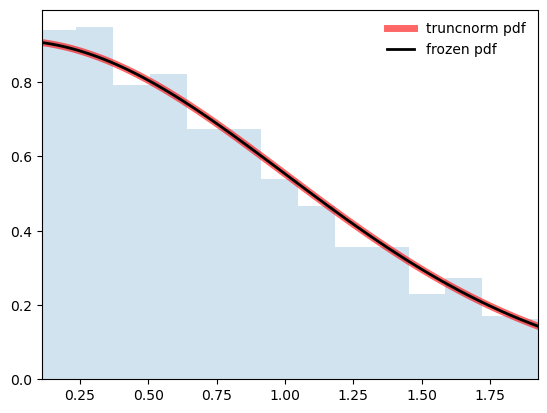

In [43]:
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
a, b = 0.1, 2

mean, var, skew, kurt = truncnorm.stats(a,b,moments='mvsk')

x = np.linspace(truncnorm.ppf(0.01,a,b),
                truncnorm.ppf(0.99,a,b), 100)
ax.plot(x, truncnorm.pdf(x,a,b), 'r-', lw=5, alpha=0.6, label ='truncnorm pdf')

rv = truncnorm(a, b)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

r = truncnorm.rvs(a, b, size=1000)

ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.set_xlim([x[0], x[-1]])
ax.legend(loc='best', frameon=False)
plt.show()

In [45]:
lower, upper = 0, np.inf
mu, sigma = b_curve, s_curve
X = truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
print(X)
random_numbers = X.rvs(size=b_curve.shape[0])
print(random_numbers)

sim_cprs = b_curve * (1-np.exp(-random_numbers))
print(sim_cprs)

[0.0148126  0.01136573 0.1284604  0.09059981 0.06956917 0.23049842
 0.17549131 0.17304827 0.05070497 0.08169891 0.13291937 0.13560559
 0.09567065 0.11312145 0.09203025 0.12824016 0.16832997 0.10816667
 0.18775786 0.10188685 0.11581188 0.16355648 0.10384954 0.10742165
 0.06786758]
[0.00014491 0.00051023 0.01086634 0.01233515 0.00983168 0.03105513
 0.02252391 0.02130441 0.00510566 0.00724755 0.01321388 0.01462103
 0.01058441 0.01222375 0.00967564 0.01351387 0.01834424 0.01097666
 0.02148859 0.0121747  0.01220693 0.02087668 0.01100778 0.01136646
 0.0073225 ]


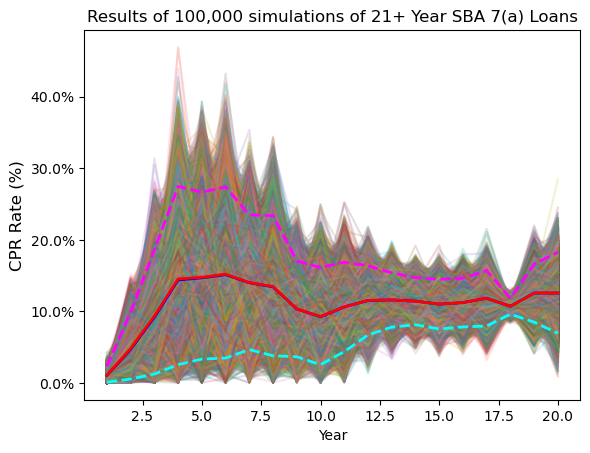

In [51]:
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

b_curve = temp['median'].values
s_curve = temp['std'].values

num_iterations = 100_000

simulated_cpr_rates_all = np.zeros((num_iterations, b_curve.shape[0]))

for i in range(num_iterations):
    lower, upper = 0, np.inf
    mu, sigma = b_curve, s_curve
    X = truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    sim_cprs = X.rvs(size=b_curve.shape[0])
    simulated_cpr_rates_all[i,:] = sim_cprs


# Calculate the median and average of the simulated CPR rates across all iterations
median_cpr_rates = np.median(simulated_cpr_rates_all, axis=0)
average_cpr_rates = np.mean(simulated_cpr_rates_all, axis=0)
# Calculate the upper and lower confidence intervals
lower_ci_cpr_rates = np.percentile(simulated_cpr_rates_all, 2.5, axis=0)
upper_ci_cpr_rates = np.percentile(simulated_cpr_rates_all, 97.5, axis=0)


plt.plot(np.arange(1, 21), simulated_cpr_rates_all[:,:20].T, alpha=0.2)
# Add a legend and axis labels
# Add a line plot of the median and average CPR rates
plt.plot(np.arange(1, 21), median_cpr_rates[:20], label='Median', lw=2, color='blue')
plt.plot(np.arange(1, 21), average_cpr_rates[:20], label='Average', lw=2, color='red')
plt.plot(np.arange(1, 21), upper_ci_cpr_rates[:20], label='Upper CI', lw=2, color='magenta', linestyle='--')
plt.plot(np.arange(1, 21), lower_ci_cpr_rates[:20], label='Lower CI', lw=2, color='cyan', linestyle='--')
plt.title('Results of {:,d} simulations of 21+ Year SBA 7(a) Loans'.format(num_iterations))
plt.xlabel('Year')
plt.ylabel('CPR')
y_fmt = mtick.PercentFormatter(xmax=1, decimals=1)

# Update the y-axis label and formatter
plt.ylabel('CPR Rate (%)', fontsize=12)
plt.gca().yaxis.set_major_formatter(y_fmt)
plt.legend()
plt.show()


In [55]:
sim_mid_max_mins = pd.DataFrame(dict(median = median_cpr_rates, average=average_cpr_rates,
                                      upper_ci=upper_ci_cpr_rates, lower_ci=lower_ci_cpr_rates))

sim_mid_max_mins.transpose().to_csv('simulation_21+baseline.csv')

In [ ]:
import numpy as np


# Define the likelihood function
def likelihood(p, alpha, beta):
    return pm.math.beta(alpha, beta).pdf(p)

# Define the prior distribution
with pm.Model() as model:
    alpha = pm.Uniform('alpha', lower=0, upper=10)
    beta = pm.Uniform('beta', lower=0, upper=10)

# Define the posterior distribution
with model:
    p = pm.Deterministic('p', alpha / (alpha + beta))
    likelihood_obs = pm.DensityDist('likelihood_obs', likelihood, observed={'p': p, 'alpha': alpha, 'beta': beta})

# Use MCMC to sample from the posterior distribution
with model:
    trace = pm.sample(draws=10000, tune=5000, chains=4, random_seed=42)

# Compute the posterior statistics
alpha_posterior = np.mean(trace['alpha'])
beta_posterior = np.mean(trace['beta'])

In [57]:
b_curve

array([0.00985573, 0.0451473 , 0.09013848, 0.14241056, 0.14629526,
       0.15085389, 0.13993893, 0.13407181, 0.10326781, 0.09238364,
       0.106166  , 0.11529593, 0.11601038, 0.11428571, 0.11004746,
       0.1122807 , 0.1184072 , 0.10706638, 0.12552876, 0.12568306,
       0.11162431, 0.13836478, 0.11159655, 0.11159655, 0.11159655])